# Fit material parameters

Given scattered material parameters, fit a polynomials to these parameters
and generate the corresponding lambda functions in python or MATLAB anonymous functions

Note: meter is converted to mm to match FE mesh dimensions. This affects LS-DYNA simulations but not FANS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate

def gen_lambda(function_name, coef):
    """
    Generate lambda functions given polynomial coefficients
    :param coef: polynomial coefficients of arbitrary degree
    :return: function is printed to the console and can be copied from there
    """
    matlab = False
    if matlab:
        out = f'{function_name} = @(x) '
        for p, c in enumerate(coef[::-1]):
            out += f'{c:.5e} * x.^{p}+'
        out = out[:-1] + ';'
    else:
        out = f'{function_name} = lambda x:'
        for p, c in enumerate(coef[::-1]):
            out += f'{c:.5e} * x**{p}+'
        out = out[:-1]
    print(out)

## Copper

poisson_ratio_cu = lambda x:3.40000e-01 * x**0
conductivity_cu = lambda x:4.00671e+02 * x**0+-6.84915e-02 * x**1
heat_capacity_cu = lambda x:3.40744e+06 * x**0+9.49940e+02 * x**1+-1.65972e+00 * x**2+1.47057e-03 * x**3
cte_cu = lambda x:1.52298e+01 * x**0+8.23091e-03 * x**1
elastic_modulus_cu = lambda x:1.30446e+02 * x**0+-4.19924e-02 * x**1+-8.16134e-05 * x**2


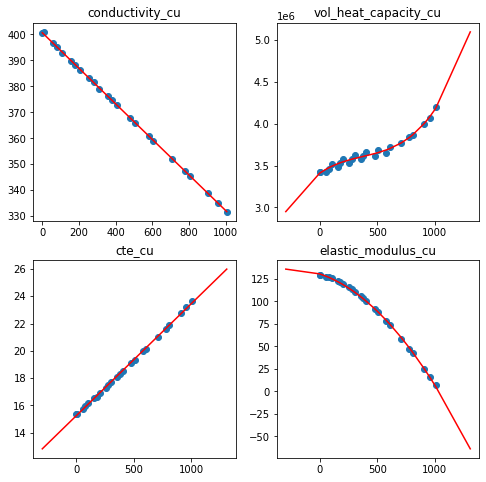

In [26]:
dataframe_cu = pd.read_excel(material_parameter_file := 'data/material_parameters.xlsx', sheet_name='copper', header=0,nrows=24)

gen_lambda('poisson_ratio_cu', [dataframe_cu.loc[0, 'nu']])

fig, ax = plt.subplots(2, 2, figsize=[8, 8])

x, y = dataframe_cu['T[K]'], dataframe_cu['k [W/m-K]']
y = y * 1e3 # change units m -> mm
deg = 1
coef = np.polyfit(x, y, deg=deg)  # c0 + c1 * x
ax[0, 0].scatter(x, y)
x = np.concatenate(([0], np.asarray(x), [1600]))
power_of_x = np.asarray([x ** p for p in range(deg, -1, -1)])
ax[0, 0].plot(x, coef @ power_of_x, c='r')
ax[0, 0].set_title('conductivity_cu')
gen_lambda('conductivity_cu', coef)

x, y = dataframe_cu['T[K]'], dataframe_cu['c_v [J/m^3 K]']
y = y * 1e-3 # change units m -> mm
deg = 3
coef = np.polyfit(x, y, deg=deg)
ax[0, 1].scatter(x, y)
x = np.concatenate(([0], np.asarray(x), [1600]))
power_of_x = np.asarray([x ** p for p in range(deg, -1, -1)])
ax[0, 1].plot(x, coef @ power_of_x, c='r')
ax[0, 1].set_title('vol_heat_capacity_cu')
gen_lambda('heat_capacity_cu', coef)

x, y = dataframe_cu['T[K]'], dataframe_cu['alpha [10e-6 m/m-k]']
y = y * 1e-6 # change units m -> mm
deg = 1
coef = np.polyfit(x, y, deg=deg)
ax[1, 0].scatter(x, y)
x = np.concatenate(([0], np.asarray(x), [1600]))
power_of_x = np.asarray([x ** p for p in range(deg, -1, -1)])
ax[1, 0].plot(x, coef @ power_of_x, c='r')
ax[1, 0].set_title('cte_cu')
gen_lambda('cte_cu', coef)

x, y = dataframe_cu['T[K]'], dataframe_cu['E [Gpa]']
y = y * 1e6 # change units m -> mm
deg = 2
coef = np.polyfit(x, y, deg=deg)
ax[1, 1].scatter(x, y)
x = np.concatenate(([0], np.asarray(x), [1600]))
power_of_x = np.asarray([x ** p for p in range(deg, -1, -1)])
ax[1, 1].plot(x, coef @ power_of_x, c='r')
ax[1, 1].set_title('elastic_modulus_cu')
ax[1, 1].set_xlim([300,1300])
ax[1, 1].set_ylim([0,1.3e8])
gen_lambda('elastic_modulus_cu', coef)

plt.show()

yield_cu = lambda x : 1.12133e+02 * x + 3.49810e+04 + 1.53393e+05 * np.tanh((x/ 1000+-6.35754e-01)/-2.06958e-01) if x < 1000 else 1200.0


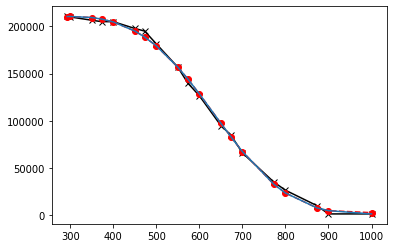

In [3]:
from scipy.optimize import curve_fit

xx, yy = dataframe_cu['T[K]'], dataframe_cu['sigma_y[Mpa]']
yy = yy * 1e3 # change units m -> mm
xx, yy = xx[:19], yy[:19]

# func = lambda x,a,b,c,d,e,f : a * x + b * x**2 + c * x**3 + d * x**4 + e * x**5 + f
func = lambda x,a,b,c,d,e : a * x + b + c * np.tanh((x+d)/e)
# func = lambda X,a,b,c,d : a * np.exp(-((X-b)/c)**2) + d

x = np.asarray(xx, dtype=np.float32) / np.max(xx)
y = np.asarray(yy, dtype=np.float32) / np.max(yy)
popt, pcov = curve_fit(func, x,y)
popt[0] *= np.max(yy)
popt[1] *= np.max(yy)
popt[2] *= np.max(yy)

plt.plot(xx,yy,label='Cu measurements',ls='-', marker='x', c='black')
plt.plot(xx,func(x,*popt),label=r'$a \ x + b \ \mathrm{tanh}(\frac{x+c}{d}) + e$',ls='--', marker='o', c='red')

a,b,c,d,e=popt
print(f'yield_cu = lambda x : {a/ np.max(xx):.5e} * x + {b:.5e} + {c:.5e} * np.tanh((x/ {np.max(xx)}+{d:.5e})/{e:.5e}) if x < {np.max(xx)} else {np.min(yy)}')

yield_cu = lambda x : 1.12133e+02 * x + 3.49810e+04 + 1.53393e+05 * np.tanh((x/ 1000+-6.35754e-01)/-2.06958e-01) if x < 1000 else 1200.0

y_=np.empty_like(yy)
for i,x_ in enumerate(xx):
    y_[i] = yield_cu(x_)
plt.plot(xx,y_)

## Tungsten

poisson_ratio_wsc = lambda x:2.80000e-01 * x**0
conductivity_wsc = lambda x:1.72914e+02 * x**0+-1.30985e-01 * x**1+8.74729e-05 * x**2+-2.01180e-08 * x**3
heat_capacity_wsc = lambda x:2.56420e+06 * x**0+5.14977e+02 * x**1+-2.24110e-01 * x**2+6.39511e-05 * x**3
cte_wsc = lambda x:5.24521e+00 * x**0+5.67524e-04 * x**1
elastic_modulus_wsc = lambda x:4.07997e+02 * x**0+-2.78605e-02 * x**1+-3.17671e-05 * x**2+5.48782e-09 * x**3


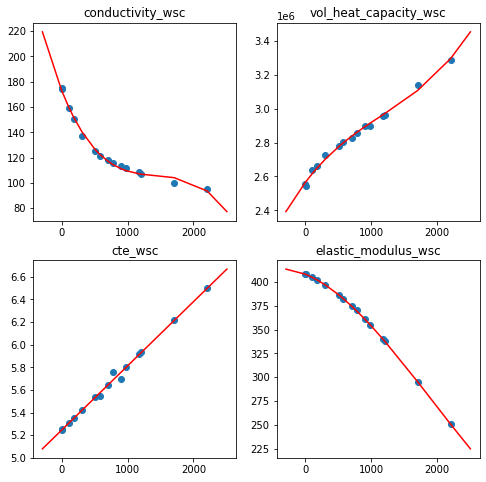

In [25]:
dataframe_wsc = pd.read_excel(material_parameter_file, sheet_name='tungsten', header=0)

gen_lambda('poisson_ratio_wsc', [dataframe_wsc.loc[0, 'nu']])

fig, ax = plt.subplots(2, 2, figsize=[8, 8])

x, y = dataframe_wsc['T[K]'], dataframe_wsc['k [W/m-K]']
y = y * 1e3 # change units m -> mm
deg = 3
coef = np.polyfit(x, y, deg=deg)  # c0 + c1 * x
ax[0, 0].scatter(x, y)
x = np.concatenate(([0], np.asarray(x), [2800]))
power_of_x = np.asarray([x ** p for p in range(deg, -1, -1)])
ax[0, 0].plot(x, coef @ power_of_x, c='r')
ax[0, 0].set_title('conductivity_wsc')
gen_lambda('conductivity_wsc', coef)

x, y = dataframe_wsc['T[K]'], dataframe_wsc['c_v [J/m^3 K]']
y = y * 1e-3 # change units m -> mm
deg = 3
coef = np.polyfit(x, y, deg=deg)
ax[0, 1].scatter(x, y)
x = np.concatenate(([0], np.asarray(x), [2800]))
power_of_x = np.asarray([x ** p for p in range(deg, -1, -1)])
ax[0, 1].plot(x, coef @ power_of_x, c='r')
ax[0, 1].set_title('vol_heat_capacity_wsc')
gen_lambda('heat_capacity_wsc', coef)

x, y = dataframe_wsc['T[K]'], dataframe_wsc['alpha [10e-6 m/m-k]']
y = y * 1e-6 # change units m -> mm
deg = 1
coef = np.polyfit(x, y, deg=deg)
ax[1, 0].scatter(x, y)
x = np.concatenate(([0], np.asarray(x), [2800]))
power_of_x = np.asarray([x ** p for p in range(deg, -1, -1)])
ax[1, 0].plot(x, coef @ power_of_x, c='r')
ax[1, 0].set_title('cte_wsc')
gen_lambda('cte_wsc', coef)

x, y = dataframe_wsc['T[K]'], dataframe_wsc['E [Gpa]']
y = y * 1e6 # change units m -> mm
deg = 3
coef = np.polyfit(x, y, deg=deg)
ax[1, 1].scatter(x, y)
x = np.concatenate(([0], np.asarray(x), [2800]))
power_of_x = np.asarray([x ** p for p in range(deg, -1, -1)])
ax[1, 1].plot(x, coef @ power_of_x, c='r')
ax[1, 1].set_title('elastic_modulus_wsc')
ax[1, 1].set_xlim([300,1300])
ax[1, 1].set_ylim([0,4.3e8])
gen_lambda('elastic_modulus_wsc', coef)

plt.show()

In [5]:
print_test_cases = False
if print_test_cases:
    print('\n')
    # print(elastic_modulus_cu(1325))

    print('')
    # print(elastic_modulus_wsc(1325))
    
    cte_cu = lambda x:1.28170e-05 * x+8.23091e-09 * x/2**2
    for x in range(293,1300):
        plt.scatter(x,integrate.quad(cte_cu, 293, x)[0])

## Temperature sampling

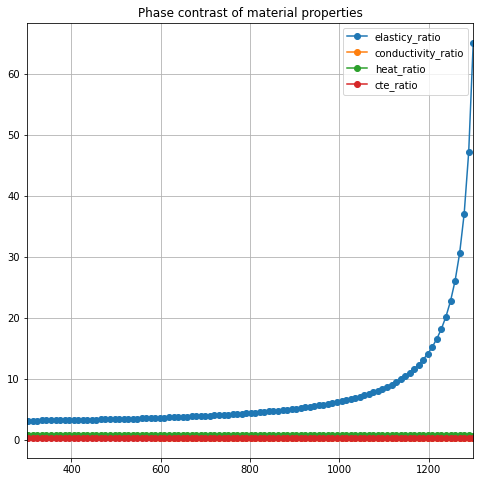

In [6]:
max_temperature = 1300
poisson_ratio_cu = lambda x:3.40000e-01 * x**0
conductivity_cu = lambda x:4.20749e+05 * x**0+-6.84915e+01 * x**1
heat_capacity_cu = lambda x:2.94929e+03 * x**0+2.30217e+00 * x**1+-2.95302e-03 * x**2+1.47057e-06 * x**3
cte_cu = lambda x:1.28170e-05 * x**0+8.23091e-09 * x**1
elastic_modulus_cu = lambda x:1.35742e+08 * x**0+5.85757e+03 * x**1+-8.16134e+01 * x**2

poisson_ratio_wsc = lambda x:2.80000e-01 * x**0
conductivity_wsc = lambda x:2.19308e+05 * x**0+-1.87425e+02 * x**1+1.05157e-01 * x**2+-2.01180e-05 * x**3
heat_capacity_wsc = lambda x:2.39247e+03 * x**0+6.62775e-01 * x**1+-2.80323e-04 * x**2+6.39511e-08 * x**3
cte_wsc = lambda x:5.07893e-06 * x**0+5.67524e-10 * x**1
elastic_modulus_wsc = lambda x:4.13295e+08 * x**0+-7.83159e+03 * x**1+-3.65909e+01 * x**2+5.48782e-03 * x**3

# thermal expansion -> thermal strain
thermal_strain_cu = lambda x: integrate.quad(cte_cu, 293, x)[0]
thermal_strain_wsc = lambda x: integrate.quad(cte_wsc, 293, x)[0]

temp_range = np.linspace(293.1, max_temperature, 100)
len_temp_range = len(temp_range)
e_ratio = np.zeros(len_temp_range)
cond_ratio = np.zeros(len_temp_range)
heat_ratio = np.zeros(len_temp_range)
# cte_ratio = np.zeros(len_temp_range)
thermal_strain_ratio = np.zeros(len_temp_range)

for idx, temp in enumerate(temp_range):
    e_ratio[idx] = elastic_modulus_wsc(temp) / elastic_modulus_cu(temp)
    cond_ratio[idx] = conductivity_wsc(temp) / conductivity_cu(temp)
    heat_ratio[idx] = heat_capacity_wsc(temp) / heat_capacity_cu(temp)
    thermal_strain_ratio[idx] = thermal_strain_wsc(temp) / thermal_strain_cu(temp)

    # for better visualization
    e_ratio[idx] =  e_ratio[idx]
    cond_ratio[idx] =  cond_ratio[idx]
    heat_ratio[idx] =  heat_ratio[idx]
    thermal_strain_ratio[idx] =  thermal_strain_ratio[idx]

fig, ax = plt.subplots(figsize=[8, 8])
ax.set_title('Phase contrast of material properties')
ax.plot(temp_range, e_ratio, marker='o', label='elasticy_ratio')
ax.plot(temp_range, cond_ratio, marker='o', label='conductivity_ratio')
ax.plot(temp_range, heat_ratio, marker='o', label='heat_ratio')
ax.plot(temp_range, thermal_strain_ratio, marker='o', label='cte_ratio')
ax.set_xlim([300,1300])
ax.grid()
ax.legend();

## Visualize effective RVE response

!!! __Careful: stiffness and conductivity should be transposed here to be used with python (the h5 file is saved using matlab)__ !!!

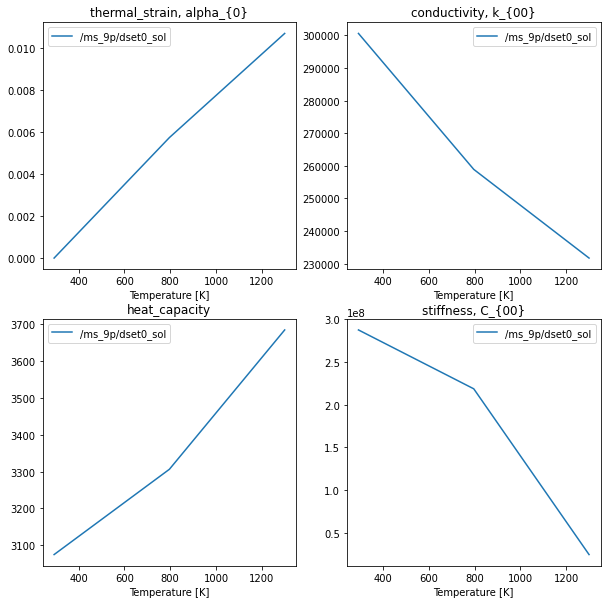

In [7]:
def get_effective_response(file_name):
    temperature_list = []
    datasets = []

    def collect_temperatures(name, node):
        """
        Get all temperatures of stored solutions and their corresponding dataset names
        e.g. /ms_random/dset9_sol/stiffness_0293.00 is split into
        0293.00 and /ms_random/dset9_sol/
        """
        if '_sol/' in name:
            temperature_list.append(name.split('_')[-1])
            datasets.append(node.name.split('_sol/')[0] + '_sol')

    with h5py.File(file_name, 'r') as file:
        for key in file.keys():
            # temperature_list.extend(file[f'{dataset}{set_id}_sol'].attrs['temperature'][:])
            solution_group = file[key]
            solution_group.visititems(collect_temperatures)

        temperature_list = list(set(temperature_list))
        temperature_list.sort()
        datasets = list(set(datasets))
        datasets.sort()

        number_of_temperatures = len(temperature_list)
        number_of_datasets = len(datasets)

        conductivity_list = np.zeros((number_of_datasets, number_of_temperatures, 3, 3))
        heat_capacity_list = np.zeros((number_of_datasets, number_of_temperatures, 1))
        thermal_strain_list = np.zeros((number_of_datasets, number_of_temperatures, 6))
        stiffness_list = np.zeros((number_of_datasets, number_of_temperatures, 6, 6))

        volume_fraction = np.zeros((len(datasets), 1))

        for set_id, dataset in enumerate(datasets):

            conductivity = np.zeros((number_of_temperatures, 3, 3))
            heat_capacity = np.zeros((number_of_temperatures, 1))
            thermal_strain = np.zeros((number_of_temperatures, 6))
            stiffness = np.zeros((number_of_temperatures, 6, 6))

            volume_fraction[set_id] = file[dataset].attrs['volume_fraction'][1]

            for key in file[dataset].keys():
                temperature_idx = temperature_list.index(temp := key.split('_')[-1])
                if key.startswith('conductivity'):
                    conductivity[temperature_idx] = file[dataset][key][:].T # * conductivity_cu(float(temp))
                elif key.startswith('heat_capacity'):
                    heat_capacity[temperature_idx] = file[dataset][key][:] # * heat_capacity_cu(float(temp))
                elif key.startswith('stiffness'):
                    stiffness[temperature_idx] = file[dataset][key][:].T # * elastic_modulus_cu(float(temp))
                elif key.startswith('thermal_strain'):
                    thermal_strain[temperature_idx] = file[dataset][key][:] # * thermal_strain_cu(float(temp))

            conductivity_list[set_id] = conductivity
            stiffness_list[set_id] = stiffness
            heat_capacity_list[set_id] = heat_capacity
            thermal_strain_list[set_id] = thermal_strain

    temperature_list = np.asarray(temperature_list).astype(float)

    return temperature_list, datasets, volume_fraction, conductivity_list, heat_capacity_list, thermal_strain_list, stiffness_list

file_name = 'data/simple_3d_rve_v03_physical.h5'

temperature_list, datasets,volume_fraction, conductivity_list, heat_capacity_list, thermal_strain_list, stiffness_list = get_effective_response(
    file_name=file_name)

fig, ax = plt.subplots(2, 2, figsize=[10, 10])
for set_id, dataset in enumerate(datasets):
    ax[0, 0].plot(temperature_list, thermal_strain_list[set_id][:, 0], label=dataset)
    ax[0, 1].plot(temperature_list, conductivity_list[set_id][:, 0, 0], label=dataset)
    ax[1, 0].plot(temperature_list, heat_capacity_list[set_id], label=dataset)
    ax[1, 1].plot(temperature_list, stiffness_list[set_id][:, 0, 0], label=dataset)

ax[0, 0].set_title('thermal_strain, alpha_{0}')
ax[0, 0].set_xlabel('Temperature [K]')
ax[0, 0].legend()

ax[0, 1].set_title('conductivity, k_{00}')
ax[0, 1].set_xlabel('Temperature [K]')
ax[0, 1].legend()

ax[1, 0].set_title('heat_capacity')
ax[1, 0].set_xlabel('Temperature [K]')
ax[1, 0].legend()

ax[1, 1].set_title('stiffness, C_{00}')
ax[1, 1].set_xlabel('Temperature [K]')
ax[1, 1].legend()




In [8]:
temp=293;
c0 = 0.6
c1 = 1 - c0

voigt_bound = lambda vol_frac0,val0,val1: vol_frac0 * val0 +(1-vol_frac0) * val1
reuss_bound = lambda vol_frac0,val0,val1: 1/(vol_frac0 / val0 +(1-vol_frac0) / val1)
voigt_bound(c0,bulk0,bulk1)
reuss_bound(c0,bulk0,bulk1)

cte_upper = (vol_frac0 * bulk0 * cte0 + vol_frac1 * bulk1 * cte1) / (vol_frac0 * bulk0 + vol_frac1 * bulk1)

bulk0 = elastic_modulus_cu(temp)/(3*(1.-2.*poisson_ratio_cu(temp)))
bulk1 = elastic_modulus_wsc(temp)/(3*(1.-2.*poisson_ratio_wsc(temp)))
shear0 = elastic_modulus_cu(temp)/ (2 * (1. + poisson_ratio_cu(temp)))
shear1 = elastic_modulus_wsc(temp)/ (2 * (1. + poisson_ratio_wsc(temp)))

CC = stiffness_list[set_id][0]
bulk = np.sum(CC[0:3,0:3])/9

# % Hashin_Shtrikman_1963_a variational approach to the elastic behavior of multiphase minerals
bulk_lower =  bulk0 + c1 / (1/(bulk1-bulk0)+3*c0/(3*bulk0+4*shear0));

# TEST: to get upper swap bulk0 and 1?
shear = shear0 + c1 / (1/(shear1-shear0)+6*c0*(bulk0+2*shear0)/(3*bulk0+4*shear0)/(5*shear0));

bulk_upper =  bulk1 + c0 / (1/(bulk0-bulk1)+3*c1/(3*bulk1+4*shear1));

# % c1*g_cte.cte1+c0*g_cte.cte0 + ((g_cte.cte0-g_cte.cte1)/(1/g_cte.bulk0-1/g_cte.bulk1))*(1/bulk_lower - c1 / g_cte.bulk1 -c0/g_cte.bulk0)
# % c1*g_cte.cte1+c0*g_cte.cte0 + ((g_cte.cte0-g_cte.cte1)/(1/g_cte.bulk0-1/g_cte.bulk1))*(1/bulk_upper - c1 / g_cte.bulk1 -c0/g_cte.bulk0)

# % the following two lines should be matching if the RVE is isotropic
# fprintf("\nRosen-Hashin effective cte: \t %e \n", c1*g_cte.cte1+c0*g_cte.cte0 + ((g_cte.cte0-g_cte.cte1)/(1/g_cte.bulk0-1/g_cte.bulk1))*(1/bulk - c1 / g_cte.bulk1 -c0/g_cte.bulk0));
# fprintf("Numerical cte                          : \t %e \n\n",mean(g_cte.cte(1:3)));

NameError: name 'bulk0' is not defined

<img src="del_attachment/effective_response.png" width="500"/>

In [9]:
set_id = datasets.index('/ms_9p/dset0_sol')
with h5py.File('data/effective_response.h5', 'w') as file:
    file.create_dataset("temperature", data=temperature_list, compression="gzip", compression_opts=0)
    file.create_dataset("conductivity", data=conductivity_list[set_id], compression="gzip", compression_opts=0)
    file.create_dataset("stiffness", data=stiffness_list[set_id], compression="gzip", compression_opts=0)
    file.create_dataset("thermal_strain", data=thermal_strain_list[set_id], compression="gzip", compression_opts=0)
    file.create_dataset("heat_capacity", data=heat_capacity_list[set_id], compression="gzip", compression_opts=0)

## Identify a simple representative volume elements (RVE)

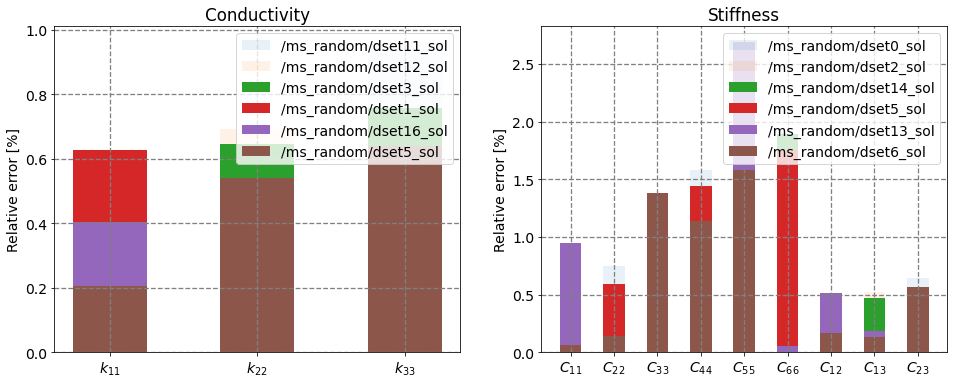

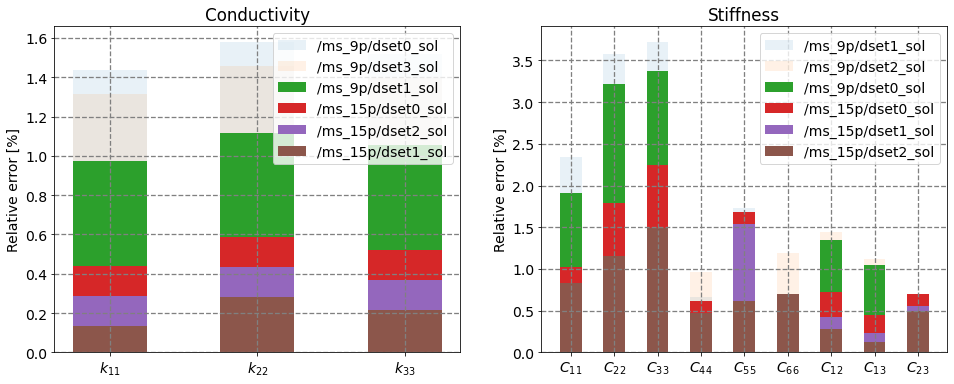

In [10]:
file_name = 'data/ct_3d_ref_v02.h5'

file = h5py.File(file_name, 'r')
ref1_conductivity_0293 = file['dset0_sol']['conductivity_0293.10'][:]
ref1_heat_capacity_0293 = file['dset0_sol']['heat_capacity_0293.10'][:]
ref1_stiffness_0293 = file['dset0_sol']['stiffness_0293.10'][:]
ref1_thermal_exp_0293 = file['dset0_sol']['thermal_exp_0293.10'][:]

# ref1_conductivity_0293 = file['dset1_sol']['conductivity_0293.10'][:]
# ref1_heat_capacity_0293 = file['dset1_sol']['heat_capacity_0293.10'][:]
# ref1_stiffness_0293 = file['dset1_sol']['stiffness_0293.10'][:]
# ref1_thermal_exp_0293 = file['dset1_sol']['thermal_exp_0293.10'][:]

file.close()

L = np.linalg.cholesky(ref1_stiffness_0293)
invL=np.linalg.inv(L)

for file_name in ['data/random_3d_rve_v02.h5','data/simple_3d_rve_v02.h5']:
    temperature_list, datasets, volume_fraction,conductivity_list, heat_capacity_list, thermal_exp_list, stiffness_list = get_effective_response(
        file_name=file_name)

    idx = np.squeeze(np.where(temperature_list == 293.10)).item()
    conductivity_error = [None] * len(datasets)
    stiffness_error = [None] * len(datasets)

    for set_id, dataset in enumerate(datasets):
        conductivity_error[set_id] = np.abs(np.diag(ref1_conductivity_0293 - conductivity_list[set_id][idx])) / np.diag(
            ref1_conductivity_0293) * 100
        stiffness_error_temp = np.abs((ref1_stiffness_0293 - stiffness_list[set_id][idx])) / (ref1_stiffness_0293) * 100
        stiffness_error_temp = np.abs(invL @ stiffness_list[set_id][idx] @ invL.T - np.eye(6)) * 100
        # TODO: check other errors based on eigenvalues or other invarient quantities
        stiffness_error[set_id] = [*np.diag(stiffness_error_temp), *stiffness_error_temp[0, [1, 2]], stiffness_error_temp[1, 2]]

    sum_conductivity_error = np.asarray([np.sum(x) for x in conductivity_error])
    sum_stiffness_error = np.asarray([np.sum(x) for x in stiffness_error])

    plt.rcParams.update({'font.size': 14})
    
    fig, ax = plt.subplots(1, 2, figsize=[16, 6])
    x = [['$k_{11}$', '$k_{22}$', '$k_{33}$'],
         ['$C_{11}$', '$C_{22}$', '$C_{33}$', '$C_{44}$', '$C_{55}$', '$C_{66}$', '$C_{12}$', '$C_{13}$', '$C_{23}$']]
    y = [conductivity_error, stiffness_error]
    title = ['Conductivity', 'Stiffness']
    for fig_id, sort_idx in enumerate([np.argsort(sum_conductivity_error)[::-1], np.argsort(sum_stiffness_error)[::-1]]):
        for set_id in sort_idx:
            if np.any(set_id == sort_idx[-4:]):
                alpha = 1
            elif np.any(set_id == sort_idx[-6:]):
                alpha = 0.1
            else:
                continue
            ax[fig_id].bar(x[fig_id], y[fig_id][set_id], label=datasets[set_id], alpha=alpha, width=0.5)
        ax[fig_id].set_title(title[fig_id])
        ax[fig_id].grid(ls='--', color='gray', linewidth=1.3)
        ax[fig_id].set_ylabel('Relative error [%]')
        ax[fig_id].legend(loc='upper right')


<table align='center'>
<tr>
<td><img src='del_attachment/ms_1p.png' width='400' /></td>
<td><img src='del_attachment/ms_9p.png' width='400' /></td>
<td><img src='del_attachment/ms_15p.png' width='400' /></td>
</tr>
</table>

In [10]:
file_name = 'data/random_3d_rve_1e4.h5'
temperature_list, datasets, volume_fraction, conductivity_list, heat_capacity_list, thermal_exp_list, stiffness_list = get_effective_response(
        file_name=file_name)

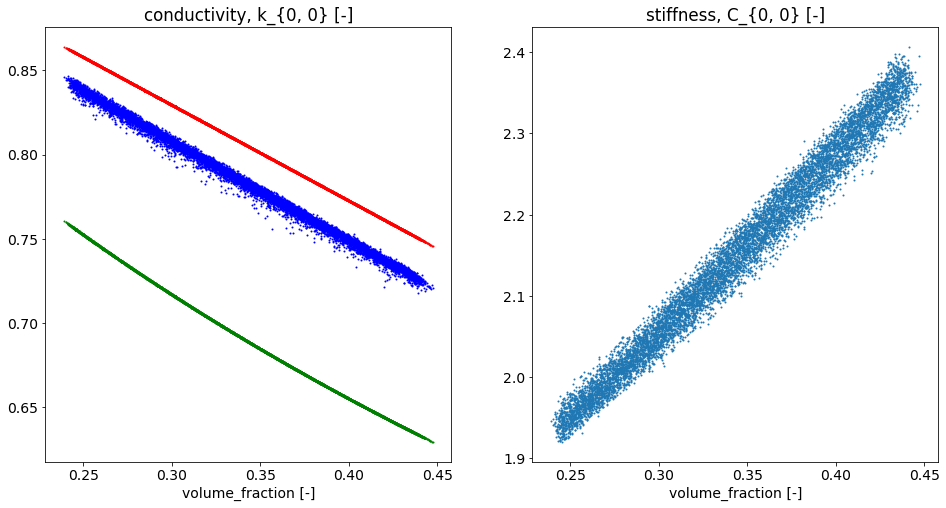

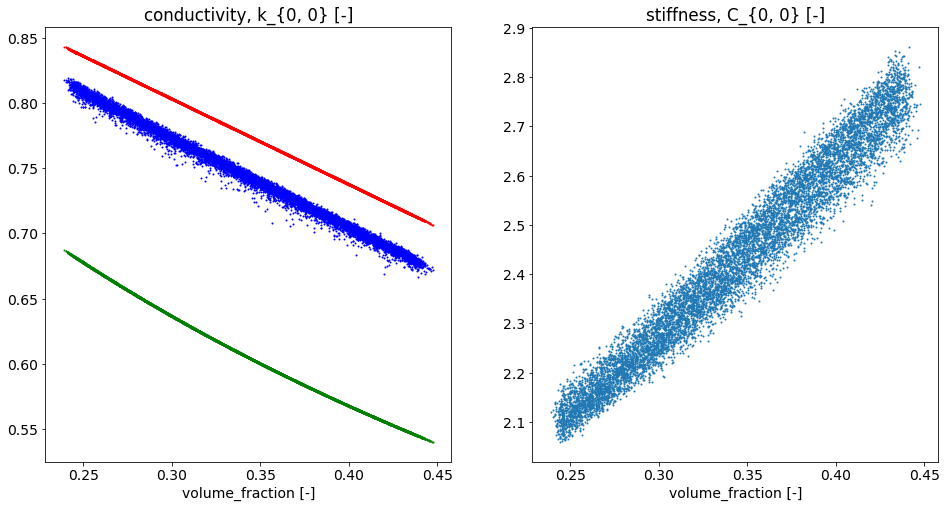

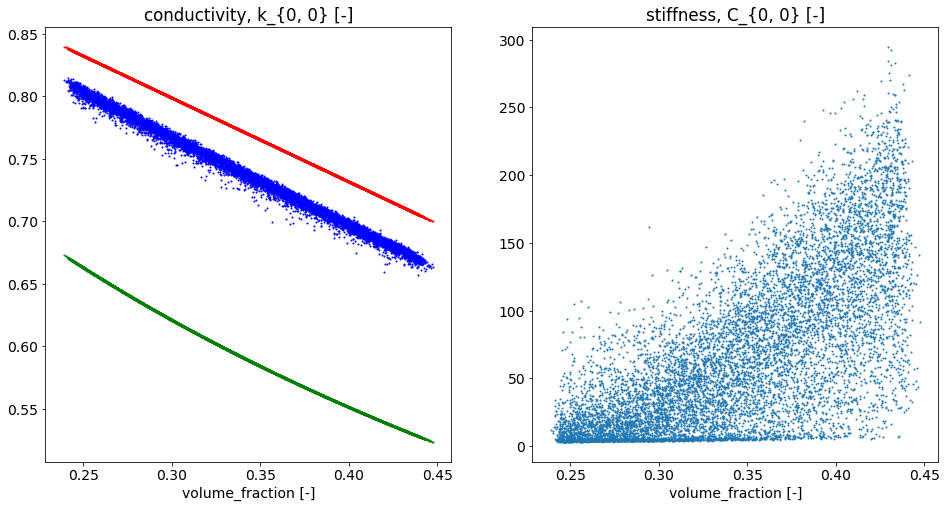

In [17]:
volume_fraction = np.asarray(volume_fraction)
y1 = volume_fraction * 0
y2 = y1 * 0
y3 = y1 * 0
y4 = y1 * 0

voigt_bound = lambda vol_frac0, val0, val1: vol_frac0 * val0 + (1 - vol_frac0) * val1
reuss_bound = lambda vol_frac0, val0, val1: 1 / (vol_frac0 / val0 + (1 - vol_frac0) / val1)

for temp_index,temp in enumerate(temperature_list):
    
    fig, ax = plt.subplots(1, 2, figsize=[16, 8])
    
    for idx, vol_frac in enumerate(volume_fraction):
        y1[idx] = conductivity_list[idx][temp_index, 0, 0]
        y2[idx] = stiffness_list[idx][temp_index, 0, 0]
        y3[idx] = voigt_bound(1 - vol_frac, 1,conductivity_wsc(temp) / conductivity_cu(temp))
        y4[idx] = reuss_bound(1 - vol_frac, 1,conductivity_wsc(temp) / conductivity_cu(temp))

    ax[0].scatter(volume_fraction, y1, s=1,c='blue')
    ax[0].scatter(volume_fraction, y3, s=1,c='red')
    ax[0].scatter(volume_fraction, y4, s=1,c='green')
    ax[1].scatter(volume_fraction, y2, s=1)

    ax[0].set_title('conductivity, k_{0, 0} [-]')
    ax[0].set_xlabel('volume_fraction [-]')

    ax[1].set_title('stiffness, C_{0, 0} [-]')
    ax[1].set_xlabel('volume_fraction [-]')

    plt.savefig(f'effective_random_3d_rve_1e4_temperature{temp}.png', dpi=400)

In [ ]:
# visualise bounds
% c1 = 0.2
% c0 = 1 - c1
upper = eigs(c0 * mat_stiffness_0 + c1 * mat_stiffness_1)

lower = eigs(inv(c0 * inv(mat_stiffness_0 ) + c1 * inv(mat_stiffness_1)))

ee = eigs(g_mechanical.hom_response)

In [39]:
# delete
file_name = 'data/simple_3d_rve_v02.h5'

file = h5py.File(file_name, 'r')
ref1_conductivity_0293 = file['ms_1p/dset0_sol']['conductivity_0293.10'][:]
ref1_heat_capacity_0293 = file['ms_1p/dset0_sol']['heat_capacity_0293.10'][:]
ref1_stiffness_0293 = file['ms_1p/dset0_sol']['stiffness_0293.10'][:]
ref1_thermal_exp_0293 = file['ms_1p/dset0_sol']['thermal_exp_0293.10'][:]